In [26]:
import matplotlib.pyplot as plt
from Functions.connection.connection import *
from Functions.Models.Logistic_regression import *
from Functions.Models.Random_forest import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.Pipelines.pipeline_NLP import *


In [27]:
creds = ["uktuserdaroglu","Vacy4201(Pri","172.20.20.4","hgo",3306]
#Connection to the database
host = creds[2]
user = creds[0]
password = creds[1]
database = creds[3]
port = creds[4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()

#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected




Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
736


In [28]:
alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [29]:
data = pre_process(alertP1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

# XGBOOST

In [30]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text_caveman','clean_text','chi_squared']#'chi_squared'
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns
#y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)


# split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)




# Convert data into DMatrix format

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)

dtest = xgb.DMatrix(X_test, enable_categorical = True)




# Set parameters for the XGBoost model

param = {

        'max_depth': 2,

         'eta': 0.4,

         'objective': 'binary:logistic',

        'seed': 16

        }




# Train the model

num_round = 6

bst = xgb.train(param, dtrain, num_round)




# Make preictions on the train set

y_pred_train = bst.predict(dtrain)

# Make predictions on the test set

y_pred_test = bst.predict(dtest)


In [12]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Precision-Recall trade-off,0.38,0.78,0.99,0.76,0.86
1,Cohen's Kappa,0.60,0.78,0.88,0.81,0.88


In [13]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Precision-Recall trade-off,0.38,0.67,1.00,0.67,0.67
1,Cohen's Kappa,0.60,0.73,0.95,0.72,0.72


In [14]:
def plot_selection_rates(X_test, y_test, y_pred, ncols=3, hspace=0.5):
    from fairlearn.metrics import MetricFrame, selection_rate
    
    #y_pred must be binary!!!
    #Hint to transform into binary:
    #thresholds = np.linspace(0, 1, 100)
    #kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
    #kappa_threshold = thresholds[np.argmax(kappas)]
    #kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)

    cols = ['outside area', 'SAM', 'SON', 'unknown', 'Other specialities', '2', '3+', 'HOSP', 'UCSP', 'USF A', 'USF B', 'outro', 'not accepted before']

    # Get the number of columns to plot
    n_cols = len(cols)
    
    # Calculate the number of rows needed to arrange the subplots in a grid with ncols columns
    nrows = math.ceil(n_cols / ncols)
    
    # Create a figure with nrows rows and ncols columns of subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    
    # Flatten the axs array to make it easier to index
    axs = axs.flatten()
    
    # Loop over the specified columns
    for i, col in enumerate(cols):
        # Create a MetricFrame object for the current column
        mf = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=X_test[col])
        
        # Plot the selection rates for each group within the current column
        mf.by_group.plot.bar(ax=axs[i], title=f'Selection Rates by {col}')
    
    # Add space between the rows of subplots
    plt.subplots_adjust(hspace=hspace)
    plt.show()

In [15]:
#y_pred must be binary!!!
    #Hint to transform into binary:
thresholds = np.linspace(0, 1, 100)
kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
kappa_threshold = thresholds[np.argmax(kappas)]
kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)

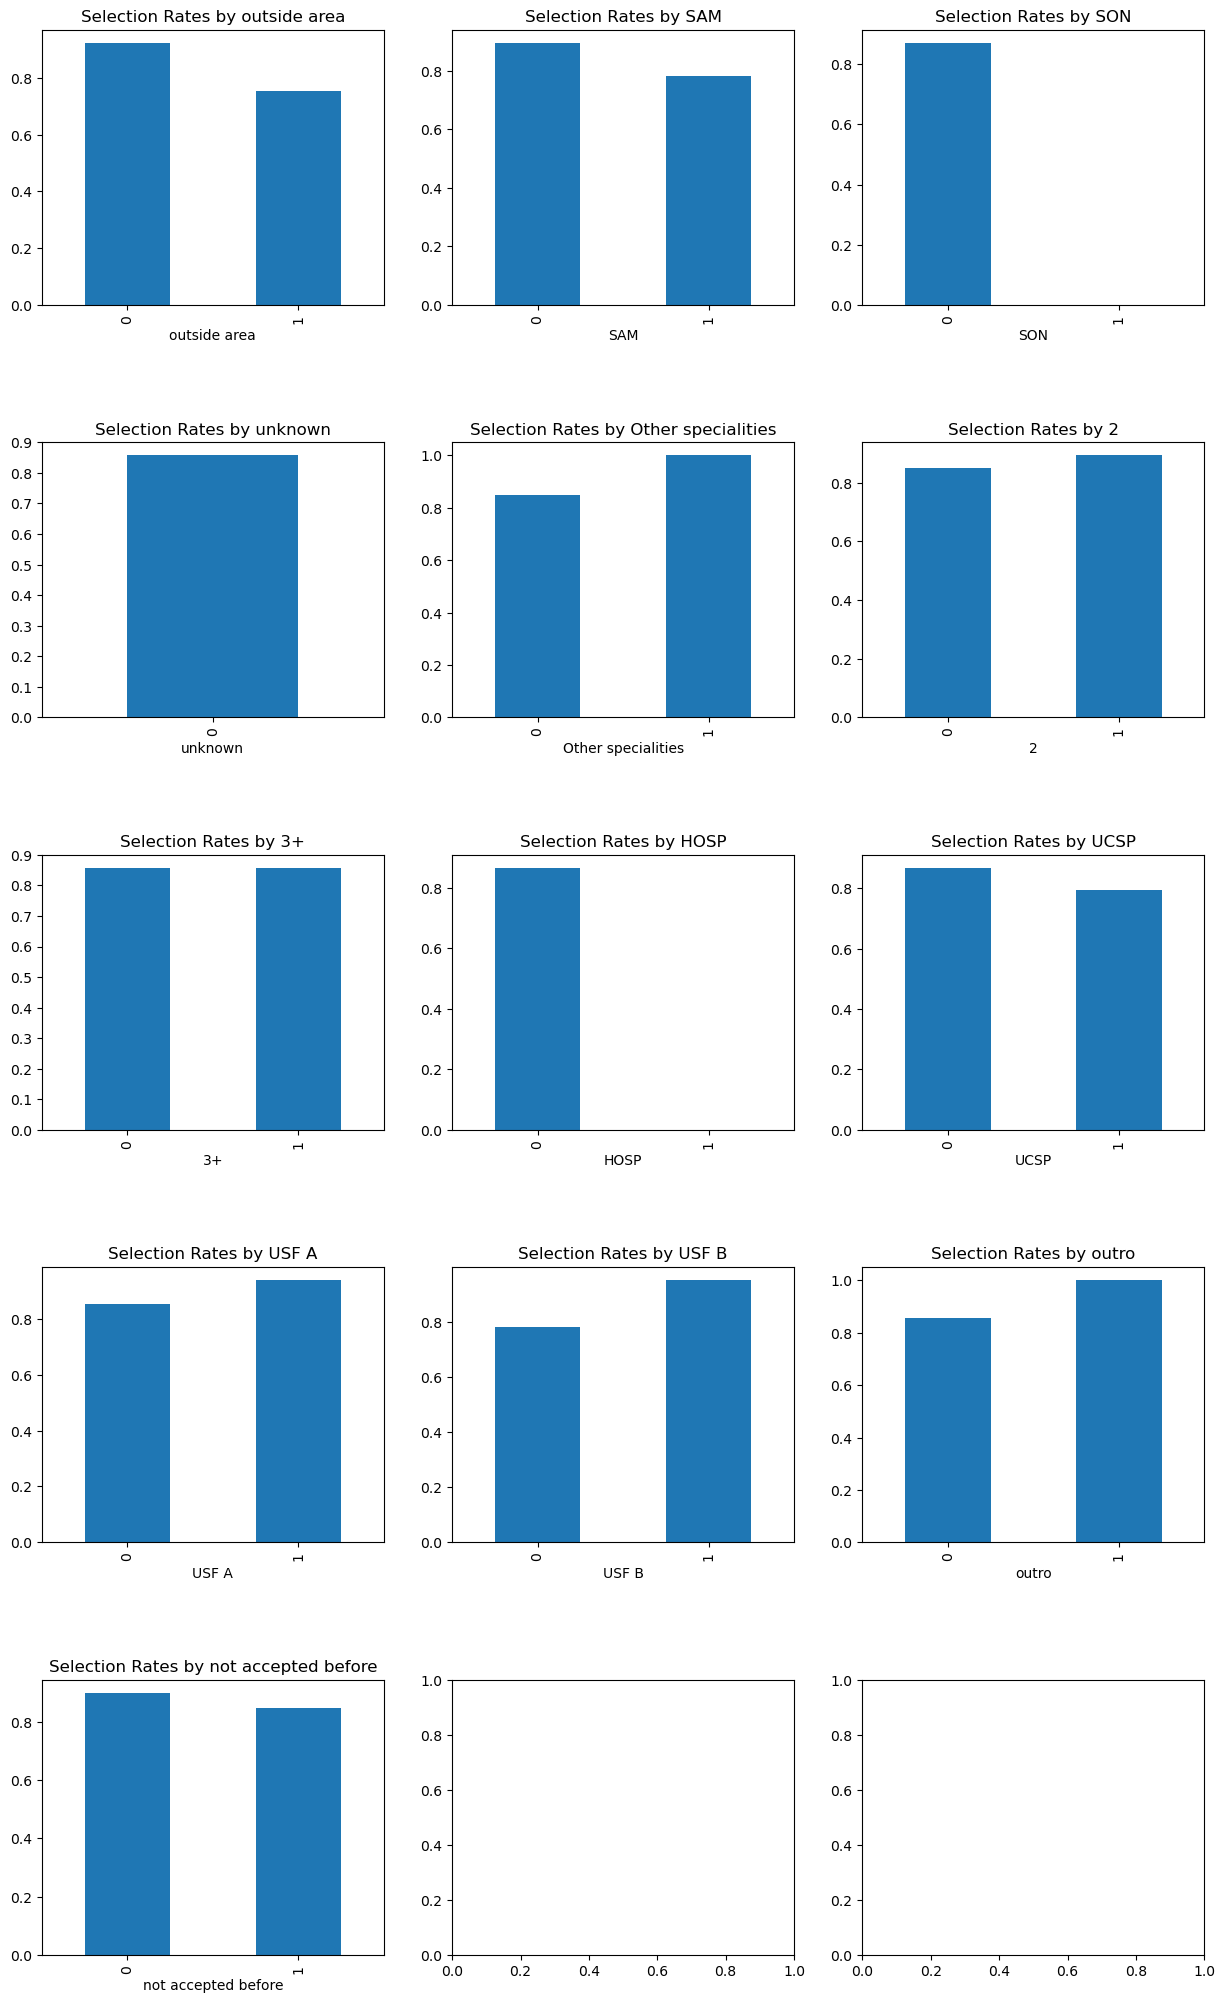

In [16]:
plot_selection_rates(X_test, y_test, kappa_y_pred_binary)

eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text','clean_text_caveman','chi_squared']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable

import shap
from Functions.Models.xgboost import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.Pipelines.pipeline_NLP import *
# Define XGBoost model 
model = xgb.XGBRegressor()
model.fit(X_train, y_train)



In [23]:
# Create a SHAP explainer using the XGBoost model
explainer = shap.Explainer(bst)

# Compute SHAP values for your dataset
shap_values = explainer.shap_values(X)

In [24]:
# Retrieve feature names from the dataset
if isinstance(X, np.ndarray):
    features = [f"Feature {i}" for i in range(X.shape[1])]
elif isinstance(X, pd.DataFrame):
    features = X.columns.tolist()
else:
    raise ValueError("Unsupported data type. Please provide X as a NumPy array or a pandas DataFrame.")

# Call the function to print feature importances based on SHAP values


def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    from scipy.special import softmax
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
    feature_importances_norm = {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse=True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
print_feature_importances_shap_values(shap_values, features)

text_length -> 0.3389 (softmax = 0.0129)
Other specialities -> 0.2790 (softmax = 0.0122)
USF B -> 0.2098 (softmax = 0.0114)
symptoms_count -> 0.1691 (softmax = 0.0109)
medication_count -> 0.0962 (softmax = 0.0102)
unknown -> 0.0956 (softmax = 0.0101)
symptom_1 -> 0.0827 (softmax = 0.0100)
dm -> 0.0155 (softmax = 0.0094)
sindrome -> 0.0089 (softmax = 0.0093)
outside area -> 0.0000 (softmax = 0.0092)
SAM -> 0.0000 (softmax = 0.0092)
SON -> 0.0000 (softmax = 0.0092)
2 -> 0.0000 (softmax = 0.0092)
3+ -> 0.0000 (softmax = 0.0092)
HOSP -> 0.0000 (softmax = 0.0092)
UCSP -> 0.0000 (softmax = 0.0092)
USF A -> 0.0000 (softmax = 0.0092)
outro -> 0.0000 (softmax = 0.0092)
not accepted before -> 0.0000 (softmax = 0.0092)
symptom_0 -> 0.0000 (softmax = 0.0092)
exam_identified -> 0.0000 (softmax = 0.0092)
comorbidity_identified -> 0.0000 (softmax = 0.0092)
medication_level_1 -> 0.0000 (softmax = 0.0092)
medication_level_2 -> 0.0000 (softmax = 0.0092)
medication_level_3 -> 0.0000 (softmax = 0.0092)
me

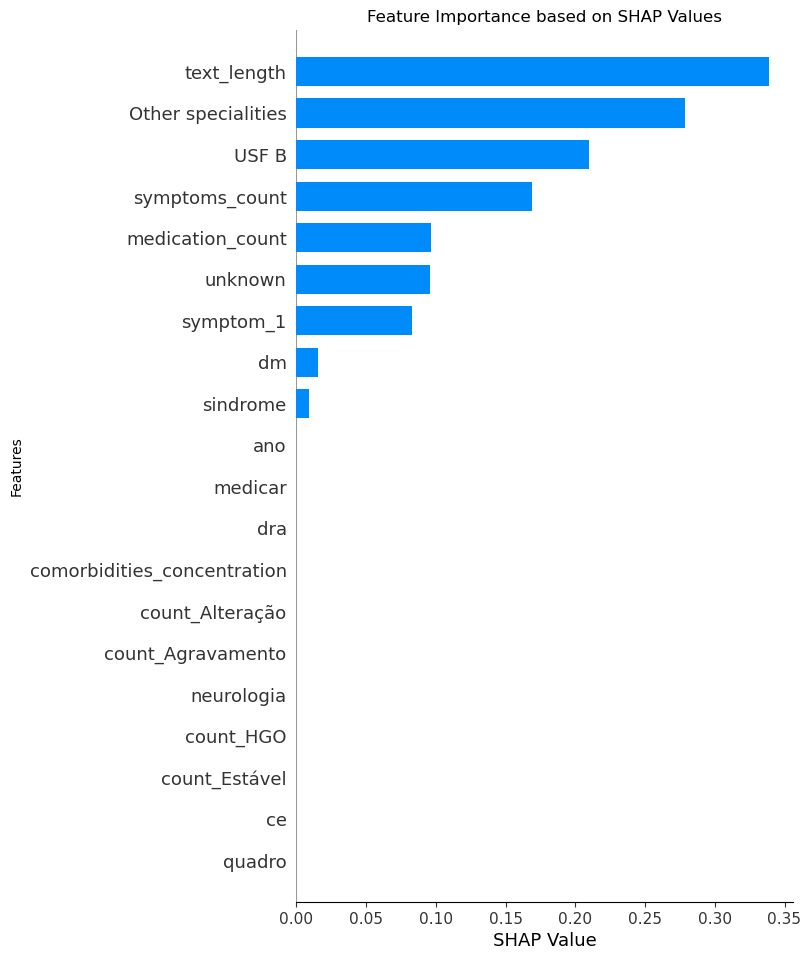

In [25]:
# Plot the SHAP values as a bar plot
shap.summary_plot(shap_values, features, plot_type='bar', show=False)
plt.xlabel("SHAP Value")
plt.ylabel("Features")
plt.title("Feature Importance based on SHAP Values")
plt.show()

ERROR: Could not find a version that satisfies the requirement softmax (from versions: none)
ERROR: No matching distribution found for softmax
Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.5/436.5 kB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 21.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


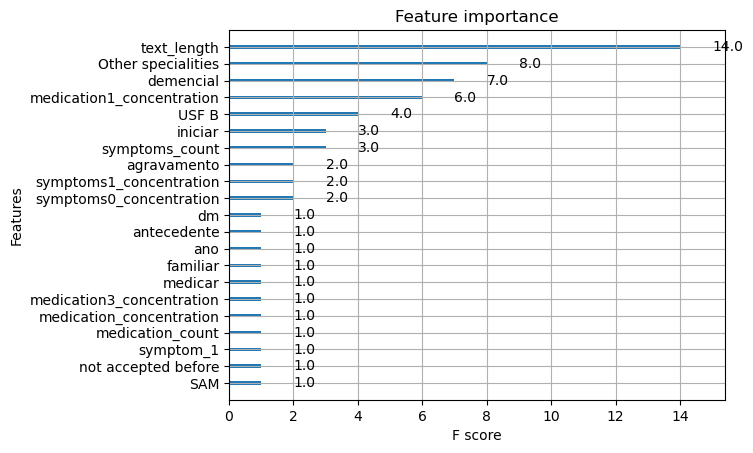

In [9]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

## combiantions

In [4]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text_caveman','clean_text','LDA_text','tf_idf text']#'chi_squared'
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns
features

Index(['text_length', 'outside area', 'SAM', 'SON', 'unknown',
       'Other specialities', '2', '3+', 'HOSP', 'UCSP',
       ...
       'dim_91', 'dim_92', 'dim_93', 'dim_94', 'dim_95', 'dim_96', 'dim_97',
       'dim_98', 'dim_99', 'dim_100'],
      dtype='object', length=173)

In [18]:
word2vec_features


Index(['dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5', 'dim_6', 'dim_7', 'dim_8',
       'dim_9', 'dim_10', 'dim_11', 'dim_12', 'dim_13', 'dim_14', 'dim_15',
       'dim_16', 'dim_17', 'dim_18', 'dim_19', 'dim_20', 'dim_21', 'dim_22',
       'dim_23', 'dim_24', 'dim_25', 'dim_26', 'dim_27', 'dim_28', 'dim_29',
       'dim_30', 'dim_31', 'dim_32', 'dim_33', 'dim_34', 'dim_35', 'dim_36',
       'dim_37', 'dim_38', 'dim_39', 'dim_40', 'dim_41', 'dim_42', 'dim_43',
       'dim_44', 'dim_45', 'dim_46', 'dim_47', 'dim_48', 'dim_49', 'dim_50',
       'dim_51', 'dim_52', 'dim_53', 'dim_54', 'dim_55', 'dim_56', 'dim_57',
       'dim_58', 'dim_59', 'dim_60', 'dim_61', 'dim_62', 'dim_63', 'dim_64',
       'dim_65', 'dim_66', 'dim_67', 'dim_68', 'dim_69', 'dim_70', 'dim_71',
       'dim_72', 'dim_73', 'dim_74', 'dim_75', 'dim_76', 'dim_77', 'dim_78',
       'dim_79', 'dim_80', 'dim_81', 'dim_82', 'dim_83', 'dim_84', 'dim_85',
       'dim_86', 'dim_87', 'dim_88', 'dim_89', 'dim_90', 'dim_91', 'dim_92'

In [14]:
non_Nlp=features[0:14]
wordsearch_features=features[14:36]
LDA_features=features[36:39]
#chi_squared_features=features[39:110]
tfidf_features=features[39:59]
bert_features=features[59:73]#bert_features=features[110:124]#
word2vec_features=features[73:]#word2vec_features=features[124:]#


from itertools import compress, product
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
  #This fonctions will be used to have every combinations of features for the model
def combinations(items):
      return ( list(set(compress(items,mask))) for mask in product(*[[0,1]]*len(items)) )


def lgbm(all_columns,y):
      new_x=X[all_columns]
      y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(new_x,y)
      thresholds = np.linspace(0, 1, 100)
       # Cohen's Kappa
      kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
      kappa_threshold = thresholds[np.argmax(kappas)]
      kappa_y_pred_train_binary = (y_pred_train >= kappa_threshold).astype(int)
      kappa_y_pred_test_binary = (y_pred_test >= kappa_threshold).astype(int)
      kappa_recall_train = recall_score(y_train, kappa_y_pred_train_binary)
      kappa_recall_test = recall_score(y_test, kappa_y_pred_test_binary)
      kappa_precision_train = precision_score(y_train, kappa_y_pred_train_binary)
      kappa_precision_test = precision_score(y_test, kappa_y_pred_test_binary)
      return(round(kappa_recall_train, 2),round(kappa_precision_train, 2),round(kappa_recall_test, 2),round(kappa_precision_test, 2))

d = pd.DataFrame(columns=["Features_used","recall train","precision train","recall test","precision test"])

all_columns = [non_Nlp,wordsearch_features,LDA_features,tfidf_features,bert_features,word2vec_features]
#all_columns = [non_Nlp,wordsearch_features,LDA_features,chi_squared_features,bert_features,word2vec_features]
  #Iterate over every combinations of features and train the model,
  #get the MAE and append it with the features used in the dataframe
combi_col = list(combinations(np.arange(start=0, stop=len(all_columns))))[1:] #starting from index 1 to drop empty list
group_names = ['non_Nlp', 'wordsearch', 'LDA','tfidf ','bert', 'Word2vec']
#group_names = ['non_Nlp', 'wordsearch', 'LDA', 'chi_squared', 'bert', 'Word2vec']

for columns in combi_col:
    selected_columns_group = [group_names[i] for i in columns]
    selected_columns = [all_columns[i] for i in columns]
    flattened_columns = [col for sublist in selected_columns for col in sublist]  # Flatten the list
    recall_train,precision_train,recall_test,precision_test = lgbm(flattened_columns, y)
    d = d.append({"Features_used": ",".join(selected_columns_group), "recall train": recall_train,"precision train": precision_train,"recall test": recall_test,"precision test": precision_test}, ignore_index=True)

d['Rank'] = d[['recall test', 'precision test']].apply(tuple,axis=1).rank(ascending=0).astype(int)
d = d.sort_values(['recall test', 'precision test'], ascending=[False, False])
d = d[["Rank", "Features_used", "recall train","precision train","recall test","precision test"]]

/tmp/ipykernel_3912187/3810816458.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append({"Features_used": ",".join(selected_columns_group), "recall train": recall_train,"precision train": precision_train,"recall test": recall_test,"precision test": precision_test}, ignore_index=True)
/tmp/ipykernel_3912187/3810816458.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append({"Features_used": ",".join(selected_columns_group), "recall train": recall_train,"precision train": precision_train,"recall test": recall_test,"precision test": precision_test}, ignore_index=True)
/tmp/ipykernel_3912187/3810816458.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append({"Features_used": ",".join(selected_col

In [19]:
# Save the dataframe to a CSV file
d.to_csv('results_tfidf.csv', index=False)

In [15]:
d.head(20)

,Rank,Features_used,recall train,precision train,recall test,precision test
4,1,"tfidf ,Word2vec",0.95,0.83,0.93,0.69
24,2,"wordsearch,LDA,Word2vec",0.94,0.85,0.92,0.70
2,3,"bert,Word2vec",0.91,0.86,0.91,0.72
44,3,"non_Nlp,LDA,tfidf ,Word2vec",0.94,0.83,0.91,0.72
28,5,"wordsearch,LDA,tfidf ,Word2vec",0.93,0.85,0.91,0.70
16,6,"wordsearch,Word2vec",0.92,0.85,0.90,0.70
20,6,"wordsearch,tfidf ,Word2vec",0.93,0.86,0.90,0.70
13,8,"LDA,tfidf ,bert",0.94,0.85,0.89,0.69
5,9,"tfidf ,bert",0.90,0.86,0.88,0.71
6,9,"tfidf ,bert,Word2vec",0.91,0.86,0.88,0.71
